In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode
# from langchain_deepseek import ChatDeepSeek
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools.tavily_search import TavilySearchResults
from uuid import uuid4
import json

In [2]:
load_dotenv()

model = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0.7,
    streaming=True, 
)

In [3]:
search_tool = TavilySearchResults(
    max_results=4,
)

In [4]:
tools = [search_tool]

memory = MemorySaver()

llm_with_tools = model.bind_tools(tools=tools)

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


In [6]:
async def agent(state: State) -> State:
    """Runs the model; it may emit tool calls."""
    ai_msg = await llm_with_tools.ainvoke(state["messages"])
    return {"messages": [ai_msg]}

def route(state: State):
    """If last AI message contains tool calls, go to ToolNode; else END."""
    last = state["messages"][-1]
    tool_calls = getattr(last, "tool_calls", None)
    if tool_calls:
        return "tools"
    return END

In [7]:
graph = StateGraph(State)

graph.add_node("agent", agent)
graph.add_node("tools", ToolNode(tools))  # <-- built-in executor for tool calls

graph.set_entry_point("agent")

# agent -> (conditional) -> tools or END
graph.add_conditional_edges("agent", route, {"tools": "tools", END: END})
# After tools run, go back to agent so the model can read tool outputs
graph.add_edge("tools", "agent")

app = graph.compile(checkpointer=memory)

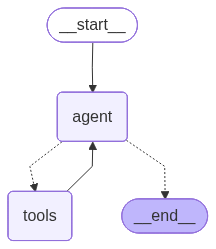

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [9]:
config = {
    "configurable": {
        "thread_id": 2
    }
}

response = await app.ainvoke({
    "messages": [HumanMessage(content="What is the current weather in ahmedabad?")]
}, config=config)

In [10]:
response

{'messages': [HumanMessage(content='What is the current weather in ahmedabad?', additional_kwargs={}, response_metadata={}, id='aba88998-1b27-4c8c-b61e-1d071637fc82'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'pqbsmk5fh', 'function': {'arguments': '{"query":"current weather in Ahmedabad"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-895a9d7a-4fee-467e-b0b0-1b3ba64dcff0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Ahmedabad'}, 'id': 'pqbsmk5fh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 195, 'output_tokens': 365, 'total_tokens': 560}),
  ToolMessage(content='[{"title": "Ahmedabad Weather Forecast 28 Sep 2025", "url": "https://timesofindia.indiatimes.com/weather/ahmedabad-weather-forecast-today/380001", "content": "## TOI\\n\\n# Ahmedabad Weather Forecast 28 Sep 2025\\n\\n114111893\\n114111895\\n114111880\\n11411189

In [12]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

async for event in app.astream_events({
    "messages": [HumanMessage(content="Write 100 word essay on Global Warming")],
}, config=config, version="v2"):

    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Write 100 word essay on Global Warming', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '8c84957c-a493-4377-be40-326c63c0ddab', 'metadata': {'thread_id': 5}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Write 100 word essay on Global Warming', additional_kwargs={}, response_metadata={}, id='24d31c9f-bf7a-4788-94f5-ef2b9be7be17')]}}, 'name': 'agent', 'tags': ['graph:step:1'], 'run_id': 'b66009f2-02d7-48f8-a658-bcae4a76244f', 'metadata': {'thread_id': 5, 'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:9296e5f5-9fbf-28a9-d0b7-1946963f8b49'}, 'parent_ids': ['8c84957c-a493-4377-be40-326c63c0ddab']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Write 